In [1]:
from collections import defaultdict, namedtuple
import numbers
import warnings
from joblib import Parallel, delayed
import numpy as np

from sklearn.utils import check_array
from sklearn.ensemble._forest import ForestClassifier
from sklearn.tree import DecisionTreeClassifier as BaseDecisionTreeClassifier
import pandas as pd
import diffprivlib
from diffprivlib.accountant import BudgetAccountant
from diffprivlib.utils import PrivacyLeakWarning
from diffprivlib.mechanisms import PermuteAndFlip
from diffprivlib.validation import DiffprivlibMixin

ImportError: cannot import name '_logistic_loss_and_grad' from 'sklearn.linear_model._logistic' (C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py)

In [2]:
#getting the data
loandf = pd.read_excel('RAIdata.xlsx')
loandf.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  IncomeFromChildSupport  \
0             87.82       0.0                       0   
1            309.23       0.0                       0   
2            143.58       0.0                       0   
3             70.65       0.0                       0   
4            719.42       0.0                       0   

   IncomeFromFamilyAllowance  IncomeFromLeavePay  ...  VerificationType_2.0  \
0                        0.0                   0  ...                     0   
1                        0.0                   0  ...                     0   
2                        0.0                   0  ...                     0   
3                        0.0                   0  ...                     0   
4                        0.0                   0  ...                     0   

   VerificationType_3.0  VerificationType_4.0  WorkExperience_10To15Years  \
0                     0                     0                           0   
1                     0                     0                           0   
2                     0                     0                           0   
3                     0                     0                           0   
4                     0                     1                           0   

   WorkExperience_15To25Years  WorkExperience_2To5Years  \
0                           0                         0   
1                           0                         1   
2                           0                         1   
3                           0                         0   
4                           0                         0   

   WorkExperience_5To10Years  WorkExperience_LessThan2Years  \
0                          1                              0   
1                          0                              0   
2                          0                              0   
3                          1                              0   
4                          0                              1   

   WorkExperience_MoreThan25Years  Young  
0                               0      0  
1                               0      0  
2                               0      1  
3                               0      0  
4                               0      1  

[5 rows x 206 columns]

In [3]:
loandf1=loandf.copy()

In [4]:
loandf1['Income']= loandf1.iloc[:, 7:15].sum(axis=1)

In [5]:
loandf1['Income']

0         900.0
1         700.0
2         765.0
3        1300.0
4         950.0
          ...  
61316     900.0
61317    1656.0
61318     882.0
61319     800.0
61320    1300.0
Name: Income, Length: 61321, dtype: float64

In [6]:
loandf1.drop(loandf1.columns[[7,8,9,10,11,12,13,14]], axis =1, inplace =True)
loandf1.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   VerificationType_3.0  VerificationType_4.0  WorkExperience_10To15Years  \
0                     0                     0                           0   
1                     0                     0                           0   
2                     0                     0                           0   
3                     0                     0                           0   
4                     0                     1                           0   

   WorkExperience_15To25Years  WorkExperience_2To5Years  \
0                           0                         0   
1                           0                         1   
2                           0                         1   
3                           0                         0   
4                           0                         0   

   WorkExperience_5To10Years  WorkExperience_LessThan2Years  \
0                          1                              0   
1                          0                              0   
2                          0                              0   
3                          1                              0   
4                          0                              1   

   WorkExperience_MoreThan25Years  Young  Income  
0                               0      0   900.0  
1                               0      0   700.0  
2                               0      1   765.0  
3                               0      0  1300.0  
4                               0      1   950.0  

[5 rows x 199 columns]

In [7]:
loandf1.drop(["WrExLess10",'VerificationType_4.0', 'VerificationType_3.0', 'VerificationType_2.0', 'VerificationType_1.0'],axis =1, inplace =True)

In [8]:
loandf1.drop(loandf1.iloc[:,20 :46], axis =1, inplace =True)

In [9]:
loandf1.drop(['WorkExperience_2To5Years','WorkExperience_10To15Years','WorkExperience_5To10Years', 'WorkExperience_LessThan2Years','WorkExperience_MoreThan25Years'], axis =1, inplace =True)

In [10]:
loandf1.drop(loandf1.loc[:, 'MonthlyPaymentDay_1': 'MonthlyPaymentDay_28'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'Rating_A': 'Rating_HR'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'NrOfDependants_4': 'NrOfDependants_10Plus'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'HomeOwnershipType_3.0': 'HomeOwnershipType_10.0'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'HomeOwnershipType_0.0': 'HomeOwnershipType_2.0'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'CreditScoreFiAsiakasTietoRiskGrade_RL4': 'CreditScoreFiAsiakasTietoRiskGrade_RL5'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'EmploymentDurationCurrentEmployer_MoreThan5Years': 'EmploymentStatus_6.0'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'UseOfLoan_0': 'UseOfLoan_110'], axis =1, inplace=True)
loandf1.drop(loandf1.loc[:, 'LanguageCode_1': 'LanguageCode_22'], axis =1, inplace=True)

In [11]:
list(loandf1.columns)

['Unnamed: 0',
 'Age',
 'AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'Interest',
 'LoanDuration',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'NrOfDependantslessthan3',
 'WrExLess5',
 'Tenant',
 'Default',
 'Country_EE',
 'Country_ES',
 'Country_FI',
 'Country_SK',
 'Education_1.0',
 'Education_2.0',
 'Education_3.0',
 'Education_4.0',
 'Education_5.0',
 'Gender_0.0',
 'Gender_1.0',
 'Gender_2.0',
 'MaritalStatus_1.0',
 'MaritalStatus_2.0',
 'MaritalStatus_3.0',
 'MaritalStatus_4.0',
 'MaritalStatus_5.0',
 'NewCreditCustomer_False',
 'NewCreditCustomer_True',
 'NrOfDependants_0',
 'NrOfDependants_1',
 'NrOfDependants_2',
 'NrOfDependants_3',
 'OccupationArea_-1.0',
 'OccupationArea_1.0',
 'OccupationArea_2.0',
 'OccupationArea_3.0',
 'OccupationArea_4.0',
 'OccupationArea_5.0',
 'OccupationArea_6.0',
 'OccupationArea_7.0',
 'OccupationArea_8.0',
 'OccupationArea_9.0',
 'OccupationArea_10.0',
 'OccupationArea_11.0',
 'Occupa

In [12]:
loandf1.drop(loandf1.loc[:, 'Country_EE': 'Country_SK'], axis =1, inplace=True)

In [13]:
#dropping NaN values
loandf2=loandf1.dropna().reset_index(drop=True)

In [14]:
loandf2.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
0                    0                           0      0   900.0  
1                    0                           0      0   700.0  
2                    0                           0      1   765.0  
3                    0                           0      0  1300.0  
4                    0                           0      1   950.0  

[5 rows x 58 columns]

Making data differentially private


In [15]:
list(loandf2.columns)

['Unnamed: 0',
 'Age',
 'AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'Interest',
 'LoanDuration',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'NrOfDependantslessthan3',
 'WrExLess5',
 'Tenant',
 'Default',
 'Education_1.0',
 'Education_2.0',
 'Education_3.0',
 'Education_4.0',
 'Education_5.0',
 'Gender_0.0',
 'Gender_1.0',
 'Gender_2.0',
 'MaritalStatus_1.0',
 'MaritalStatus_2.0',
 'MaritalStatus_3.0',
 'MaritalStatus_4.0',
 'MaritalStatus_5.0',
 'NewCreditCustomer_False',
 'NewCreditCustomer_True',
 'NrOfDependants_0',
 'NrOfDependants_1',
 'NrOfDependants_2',
 'NrOfDependants_3',
 'OccupationArea_-1.0',
 'OccupationArea_1.0',
 'OccupationArea_2.0',
 'OccupationArea_3.0',
 'OccupationArea_4.0',
 'OccupationArea_5.0',
 'OccupationArea_6.0',
 'OccupationArea_7.0',
 'OccupationArea_8.0',
 'OccupationArea_9.0',
 'OccupationArea_10.0',
 'OccupationArea_11.0',
 'OccupationArea_12.0',
 'OccupationArea_13.0',
 'OccupationArea_14.

In [16]:
#making a seperate differential private dataset
dploan = loandf2.copy(deep =True)
dploan.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
0                    0                           0      0   900.0  
1                    0                           0      0   700.0  
2                    0                           0      1   765.0  
3                    0                           0      0  1300.0  
4                    0                           0      1   950.0  

[5 rows x 58 columns]

In [17]:
# adding noise to age column
senstivity =1
epsilon =1
dp_age=[]

original = loandf2['Age']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_age.append(value)

        
dploan['Age']=dp_age  

In [18]:
#noise to AppliedAmount column
senstivity =1
epsilon =0.1
dp_AppliedAmount=[]

original = loandf2['AppliedAmount']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_AppliedAmount.append(value)
dploan['AppliedAmount']=dp_AppliedAmount

In [19]:
senstivity =1
epsilon =0.1
dp_ExpectedLoss=[]

original = loandf2['ExpectedLoss']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        dp_ExpectedLoss.append(value)

dploan['ExpectedLoss']=dp_ExpectedLoss

In [20]:
senstivity =1
epsilon =0.1
dp_Income=[]

original = loandf2['Income']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_Income.append(value)
dploan['Income']=dp_Income

In [21]:
senstivity =1
epsilon =1
dp_Liabilities=[]

original = loandf2['LiabilitiesTotal']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        dp_Liabilities.append(value)
dploan['LiabilitiesTotal']=dp_Liabilities

In [22]:
senstivity =1
epsilon =1
dp_DebtToIncome=[]

original = loandf2['DebtToIncome']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_DebtToIncome.append(value)
dploan['DebtToIncome']=dp_DebtToIncome

In [23]:
senstivity =1
epsilon =1
dp_FreeCash=[]

original = loandf2['FreeCash']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        value = round(value)
        dp_FreeCash.append(value)
dploan['FreeCash']=dp_FreeCash

In [24]:
senstivity =1
epsilon =1
dp_LossGivenDefault=[]

original = loandf2['LossGivenDefault']

for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=senstivity/epsilon)
        dp_LossGivenDefault.append(value)
dploan['LossGivenDefault']=dp_LossGivenDefault

In [25]:
#defining a fucntion which will add noise to a pecific column
#MonthlyPayment
def privatize(feature, featuredp, sensitivity, epsilon):
    dp_1=[]

    original = feature
    for i in range(0,55353):
        value=original[i] +  np.random.laplace(loc=0, scale=sensitivity/epsilon)
        dp_1.append(value)


    featuredp=dp_1


privatize(loandf2['MonthlyPayment'], dploan['MonthlyPayment'], 1, 1)

In [26]:
#adding noise to proabaility of default column using the function we made
privatize(loandf2['ProbabilityOfDefault'], dploan["ProbabilityOfDefault"], 1, 1)

In [27]:
privatize(loandf2['Interest'], dploan["Interest"], 1, 1)

In [28]:
#preview of our differential privae dataset
dploan.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54           8505             0    -12.902152   
1           1   52           2231             0      8.568662   
2           2   27            468             1    -13.547612   
3           3   41           1333             0     -3.334472   
4           4   30            525             2     -2.839603   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0         87.394163         1     30.22            36          0.874445  ...   
1        310.311814         0     17.53            60          2.484980  ...   
2        139.829305         0     15.13            60         -2.173737  ...   
3         70.199645         2     19.10            60          2.788226  ...   
4        719.476193         0     14.32            60          1.777951  ...   

   OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
0                    0                           0      0     926  
1                    0                           0      0     701  
2                    0                           0      1     770  
3                    0                           0      0    1281  
4                    0                           0      1     961  

[5 rows x 58 columns]

In [29]:
#preview of our raw dataset
loandf2.head()

Unnamed: 0  Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0   54         8505.0           0.0      0.118622   
1           1   52         2230.0           0.0      0.059200   
2           2   28          530.0           0.0      0.048764   
3           3   40         1380.0           0.0      0.071894   
4           4   31          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  Interest  LoanDuration  LossGivenDefault  ...  \
0             87.82       0.0     30.22            36          0.638705  ...   
1            309.23       0.0     17.53            60          0.429112  ...   
2            143.58       0.0     15.13            60          0.524213  ...   
3             70.65       0.0     19.10            60          0.471205  ...   
4            719.42       0.0     14.32            60          0.521446  ...   

   OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
0                    0                           0      0   900.0  
1                    0                           0      0   700.0  
2                    0                           0      1   765.0  
3                    0                           0      0  1300.0  
4                    0                           0      1   950.0  

[5 rows x 58 columns]

In [30]:
y = dploan['Default'].values
y = y.astype('int')

In [31]:
X=dploan.drop(labels=['Default'], axis=1)

In [32]:
#dropping the unneccesary unamed column
X = X.loc[:, ~X.columns.str.contains('^Unnamed')]
X

Age  AppliedAmount  DebtToIncome  ExpectedLoss  LiabilitiesTotal  \
0       54           8505             0    -12.902152         87.394163   
1       52           2231             0      8.568662        310.311814   
2       27            468             1    -13.547612        139.829305   
3       41           1333             0     -3.334472         70.199645   
4       30            525             2     -2.839603        719.476193   
...    ...            ...           ...           ...               ...   
55348   34           6800            -1     -7.419711        192.941825   
55349   47            513             2     11.407828       1311.007797   
55350   28            529            -1      3.452975        196.745173   
55351   50           4508             0    -37.442428          0.290114   
55352   33           2082             0     -3.157113         -0.163987   

       FreeCash  Interest  LoanDuration  LossGivenDefault  MonthlyPayment  \
0             1     30.22            36          0.874445          390.43   
1             0     17.53            60          2.484980           63.49   
2             0     15.13            60         -2.173737           14.42   
3             2     19.10            60          2.788226           40.47   
4             0     14.32            60          1.777951           14.19   
...         ...       ...           ...               ...             ...   
55348         2     31.35            60          1.533027          248.34   
55349         2     16.89            36          0.945215           20.64   
55350         0     36.27            60          0.021106           21.01   
55351        -2     30.50            60          0.352992          160.71   
55352         2     28.08            60          0.618128           73.35   

       ...  OccupationArea_13.0  OccupationArea_14.0  OccupationArea_15.0  \
0      ...                    0                    0                    0   
1      ...                    0                    0                    0   
2      ...                    0                    0                    0   
3      ...                    0                    0                    0   
4      ...                    0                    0                    0   
...    ...                  ...                  ...                  ...   
55348  ...                    0                    0                    0   
55349  ...                    0                    0                    0   
55350  ...                    0                    0                    0   
55351  ...                    0                    0                    0   
55352  ...                    0                    0                    0   

       OccupationArea_16.0  OccupationArea_17.0  OccupationArea_18.0  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
55348                    0                    0                    0   
55349                    0                    0                    0   
55350                    0                    0                    0   
55351                    0                    0                    0   
55352                    0                    0                    0   

       OccupationArea_19.0  WorkExperience_15To25Years  Young  Income  
0                        0                           0      0     926  
1                        0                           0      0     701  
2                        0                           0      1     770  
3                        0                           0      0    1281  
4                        0     

[0.05933075 0.06482081 0.0586538  0.05609527 0.06197159 0.05047486
 0.06681126 0.03478593 0.05629068 0.06026785 0.07153473 0.00175446
 0.0141484  0.01466884 0.00310193 0.00836577 0.0072181  0.00903192
 0.00900441 0.00797548 0.00807321 0.00012476 0.00647225 0.01037253
 0.0098273  0.0288332  0.00126873 0.00639097 0.00649229 0.01583456
 0.00786063 0.00503686 0.00272437 0.03309088 0.00838991 0.00060595
 0.00619329 0.00195808 0.00070705 0.00560427 0.00567824 0.00441855
 0.00377687 0.00304167 0.00240062 0.00124751 0.00205665 0.00127536
 0.00283392 0.00239374 0.00288732 0.00199791 0.00327389 0.00718902
 0.01214455 0.06121625]


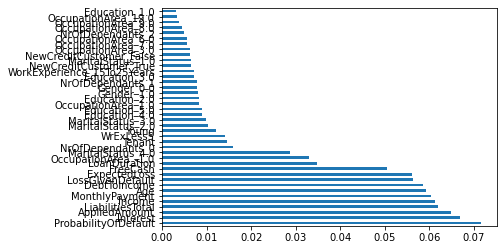

In [33]:
#checking which features has the most effect on the y column
import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')
plt.show()

In [35]:
feat_importances.nlargest(40)

ProbabilityOfDefault          0.071535
Interest                      0.066811
AppliedAmount                 0.064821
LiabilitiesTotal              0.061972
Income                        0.061216
MonthlyPayment                0.060268
Age                           0.059331
DebtToIncome                  0.058654
LossGivenDefault              0.056291
ExpectedLoss                  0.056095
FreeCash                      0.050475
LoanDuration                  0.034786
OccupationArea_-1.0           0.033091
MaritalStatus_4.0             0.028833
NrOfDependants_0              0.015835
Tenant                        0.014669
WrExLess5                     0.014148
Young                         0.012145
MaritalStatus_2.0             0.010373
MaritalStatus_3.0             0.009827
Education_4.0                 0.009032
Education_5.0                 0.009004
OccupationArea_1.0            0.008390
Education_2.0                 0.008366
Gender_1.0                    0.008073
Gender_0.0               

In [33]:
#using only top features
X =X[[ "ExpectedLoss", "LossGivenDefault", 'DebtToIncome', 'Age', 'MonthlyPayment', 'Income','LiabilitiesTotal','AppliedAmount','Interest','ProbabilityOfDefault','FreeCash','LoanDuration','OccupationArea_-1.0','MaritalStatus_4.0','Tenant','NrOfDependants_0','WrExLess5','Young','MaritalStatus_3.0',"MaritalStatus_2.0",'Education_4.0','Education_5.0','OccupationArea_1.0','Education_2.0','Gender_1.0','Gender_0.0','NrOfDependants_1','Education_3.0']]

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test=train_test_split(X,y, test_size=0.3,random_state=420)

In [35]:
X_train

ExpectedLoss  LossGivenDefault  DebtToIncome  Age  MonthlyPayment  \
16256      0.246522         -0.757345             1   34           29.03   
14103     -6.454658         -0.559211             0   44           75.83   
36541    -55.377561          1.208182             0   42           28.88   
15937    -11.895163          0.294490             0   34           55.80   
21029      6.242482         -2.706956            59   31          177.20   
...             ...               ...           ...  ...             ...   
47022    -13.443915          1.022314             1   51          132.25   
51827    -13.788732          0.259094             1   42          202.64   
21055     12.173516         -0.090505            51   38          358.01   
53638     -9.495656          4.945339             1   46           71.94   
11185     11.519436         -0.991936            58   23           44.37   

       Income  LiabilitiesTotal  AppliedAmount  Interest  \
16256    1798        355.862118           1159     10.68   
14103    1294          0.019746           1062     27.07   
36541    1382         77.824583            544     20.50   
15937     752        323.161045           2118     13.34   
21029    1290        465.308820           6058     18.94   
...       ...               ...            ...       ...   
47022     384        249.665508           3197     33.70   
51827    2005         -0.311985           4236     33.42   
21055    2687        722.947732           7763     30.64   
53638    5446       2164.209727           1914     14.32   
11185    1257        545.515700            947     31.23   

       ProbabilityOfDefault  ...  MaritalStatus_3.0  MaritalStatus_2.0  \
16256              0.123386  ...                  0                  0   
14103              0.194311  ...                  0                  0   
36541              0.168554  ...                  0                  0   
15937              0.176569  ...                  0                  0   
21029              0.141261  ...                  1                  0   
...                     ...  ...                ...                ...   
47022              0.266418  ...                  0                  0   
51827              0.247321  ...                  0                  0   
21055              0.216098  ...                  1                  0   
53638              0.150039  ...                  0                  0   
11185              0.276369  ...                  1                  0   

       Education_4.0  Education_5.0  OccupationArea_1.0  Education_2.0  \
16256              0              1                   0              0   
14103              1              0                   0              0   
36541              1              0                   0              0   
15937              0              0                   0              0   
21029              0              0                   0              1   
...              ...            ...                 ...            ...   
47022              1              0                   0              0   
51827              0              0                   0              0   
21055              1              0                   0              0   
53638              1              0                   0              0   
11185              0              0                   0              0   

       Gender_1.0  Gender_0.0  NrOfDependants_1  Education_3.0  
16256           0           1                 0              0  
14103           0           1                 0              0  
36541           0           1                 0              0  
15937           0           1                 0              1  
21029           1           0                 0              0  
...           ...         ...               ...            ...  
47022           1           0                 0              0  
51827           0           1                 0              1  
21055     

In [47]:
#nonprivate model
from sklearn.ensemble import RandomForestClassifier
model1=RandomForestClassifier(n_estimators=100,random_state=30 )
model1.fit(X_train,y_train)
prediction_test1=model1.predict(X_test)

In [52]:
realpred_proba= model1.predict_proba(X_test)[:,1]

In [61]:
#accuracy if take only 21 columns
from sklearn.metrics import accuracy_score
print ("Accuracy = ", accuracy_score(y_test, prediction_test1))
accu_real = accuracy_score(y_test, prediction_test1)

Accuracy =  0.7907985065638926


In [51]:
# accuracy for 28 columns
from sklearn.metrics import accuracy_score
print ("Accuracy = ", accuracy_score(y_test, prediction_test1))
accu_real = accuracy_score(y_test, prediction_test1)

Accuracy =  0.7942310008430687


In [52]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
f1real = f1_score(y_test, prediction_test1)
recallreal = recall_score(y_test,prediction_test1 )
precisionreal=precision_score(y_test, prediction_test1)
print("F1_score of nonprivate model with private data =", f1real)
print("Recall of nonprivate model with private data =", recallreal)
print("Precision of nonprivate model with private data =", precisionreal)

F1_score of nonprivate model with private data = 0.41798671435871226
Recall of nonprivate model with private data = 0.31134229890890636
Precision of nonprivate model with private data = 0.6357512953367875


In [62]:
#for21
f1real = f1_score(y_test, prediction_test1)
recallreal = recall_score(y_test,prediction_test1 )
precisionreal=precision_score(y_test, prediction_test1)
print("F1_score of nonprivate model with private data =", f1real)
print("Recall of nonprivate model with private data =", recallreal)
print("Precision of nonprivate model with private data =", precisionreal)


F1_score of nonprivate model with private data = 0.403707518022657
Recall of nonprivate model with private data = 0.2984014209591474
Precision of nonprivate model with private data = 0.6238726790450928


In [63]:
from numpy import arange
from sklearn.datasets import make_classification
from diffprivlib.models import RandomForestClassifier
from sklearn.metrics import accuracy_score
model=RandomForestClassifier(n_estimators=100,random_state=30, epsilon=1, n_jobs=1, verbose=0, accountant=None, feature_domains=None)

model.fit(X_train,y_train)
prediction_test=model.predict(X_test)
Accofdp=(accuracy_score(y_test, prediction_test))
f1=(f1_score(y_test, prediction_test))
recall=(recall_score(y_test, prediction_test))
precision=(precision_score(y_test, prediction_test))

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(


In [44]:
#for 40 columns
Accofdp

0.7643622786944478

In [54]:
#for 28 columns
Accofdp

0.7672528001927015

In [64]:
#for 21 columns
Accofdp

0.7668312658075395

In [142]:
#for 35 columns
f1,recall, precision

(0.17448524729356826, 0.10428825171276326, 0.5337662337662338)

In [45]:
#for 40 columns
f1,recall, precision

(0.15577130528586838, 0.09160111646790155, 0.5201729106628242)

In [55]:
#for 28 columns
f1,recall, precision

(0.16504644631669907, 0.09692971327074347, 0.5552325581395349)

In [65]:
#for 21 columns
f1,recall, precision

(0.13261648745519716, 0.07510784064958133, 0.5659655831739961)

In [ ]:
#we've only used different number of columns to check at which optimum number we get the best result. after this we've used all 57 columns, so please resort the X dataset back to 57 columns

In [48]:
#from this part of plotting the fluctuation of accuracy with epsilons, we've used all the columns that is 57, following predictions have also bee done using all 57 columns
from numpy import arange
from sklearn.datasets import make_classification
from diffprivlib.models import RandomForestClassifier
from sklearn.metrics import accuracy_score
Accofdp=[]
f1 =[]
recall =[]
precision =[]
pred_prob=[]
for i in arange(0.1, 4.0, 0.1):
    model=RandomForestClassifier(n_estimators=100,random_state=30,  epsilon=i, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,
                 max_depth=15, feature_domains=None)

    model.fit(X_train,y_train)
    prediction_test=model.predict(X_test)
    Accofdp.append(accuracy_score(y_test, prediction_test))
    f1.append(f1_score(y_test, prediction_test, average ='binary'))
    recall.append(recall_score(y_test, prediction_test, average ='binary'))
    precision.append(precision_score(y_test, prediction_test, average ='binary'))
    pred_prob.append(model.predict_proba(X_test)[:,1])

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may 

In [49]:
accdp_mean= np.average(Accofdp)
f1_mean=np.average(f1)
precision_mean=np.average(precision)
recall_mean=np.average(recall)

In [57]:
print("max accuracy of private model with private data", max(Accofdp))
print("min accuracy of private model with private data", min(Accofdp))
print("Accuracy of non private model with private data", accu_real)

max accuracy of private model with private data 0.7636396483198844
min accuracy of private model with private data 0.7617728531855956
Accuracy of non private model with private data 0.7945923160303505


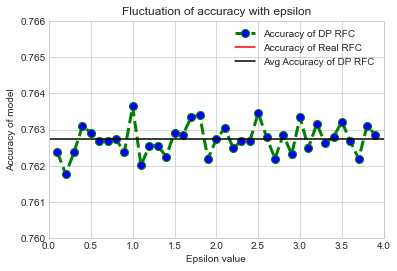

In [55]:
import matplotlib.pyplot as plt
x= arange(0.1,4.0, 0.1)
plt.plot(x, Accofdp, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'Accuracy of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=accu_real, color ='red', label= 'Accuracy of Real RFC')
plt.axhline(y =accdp_mean, color ='black', label ='Avg Accuracy of DP RFC')
plt.ylim(0.76, 0.766)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('Accuracy of model')
plt.title('Fluctuation of accuracy with epsilon')
plt.legend()
plt.show()


In [58]:
print("max f1 score of private model with private data", max(f1))
print("min f1 score of private model with private data", min(f1))
print("F1 score of non private model with private data", f1real)

max f1 score of private model with private data 0.06181645268663813
min f1 score of private model with private data 0.005535983895319577
F1 score of non private model with private data 0.41602465331278893


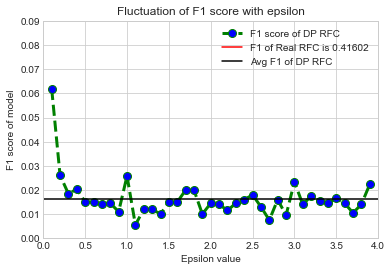

In [61]:
x= arange(0.1,4.0, 0.1)
plt.plot(x, f1, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'F1 score of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=f1real, color ='red', label= 'F1 of Real RFC is 0.41602')
plt.axhline(y =f1_mean, color ='black', label ='Avg F1 of DP RFC')
plt.ylim(0, 0.09)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('F1 score of model')
plt.title('Fluctuation of F1 score with epsilon')
plt.legend()
plt.show()

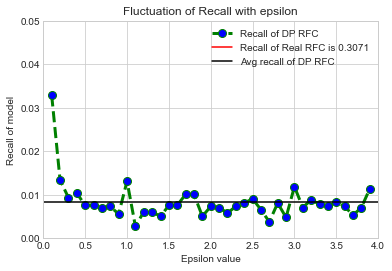

In [63]:
x= arange(0.1,4.0, 0.1)
plt.plot(x, recall, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'Recall of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=recallreal, color ='red', label= 'Recall of Real RFC is 0.3071')
plt.axhline(y =recall_mean, color ='black', label ='Avg recall of DP RFC')
plt.ylim(0, 0.05)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('Recall of model')
plt.title('Fluctuation of Recall with epsilon')
plt.legend()
plt.show()

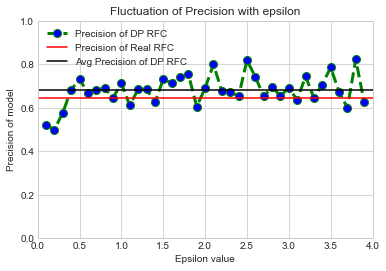

In [62]:
x= arange(0.1,4.0, 0.1)
plt.plot(x, precision, color ='green',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8, label = 'Precision of DP RFC')
plt.style.use('seaborn-whitegrid')

plt.axhline(y=precisionreal, color ='red', label= 'Precision of Real RFC')
plt.axhline(y =precision_mean, color ='black', label ='Avg Precision of DP RFC')
plt.ylim(0, 1)
plt.xlim(0,4)
plt.xlabel('Epsilon value')
plt.ylabel('Precision of model')
plt.title('Fluctuation of Precision with epsilon')
plt.legend()
plt.show()

In [65]:
#plotting roc curve and  getting auc score
from sklearn.metrics import roc_curve,roc_auc_score
def plot_roc_curve(fpr,tpr, v=str()): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(v)
    plt.show() 

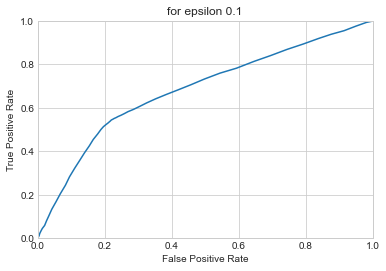

In [67]:
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[0])
plot_roc_curve(fpr, tpr, "for epsilon 0.1")

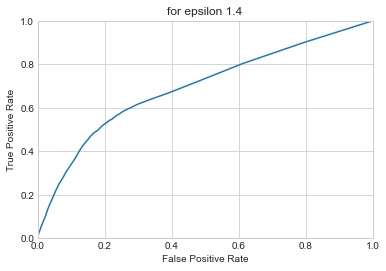

In [69]:
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[15])
plot_roc_curve(fpr, tpr, "for epsilon 1.4")

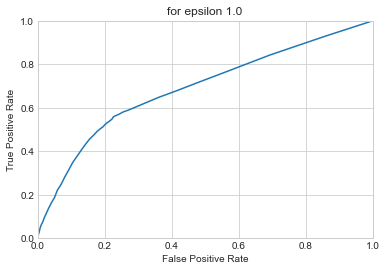

In [70]:
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[9])
plot_roc_curve(fpr, tpr, "for epsilon 1.0")

In [74]:
from sklearn import metrics
auc_dp= metrics.roc_auc_score(y_test, pred_prob[9] )
print('AUC score for private model,e =1.0, with private data =', auc_dp)

AUC score for private model,e =1.0, with private data = 0.6885516571615837


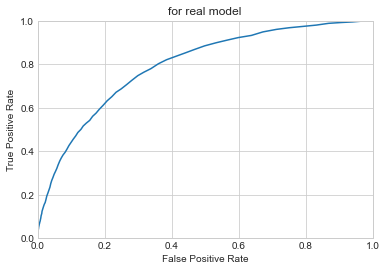

In [72]:
fpr , tpr , thresholds = roc_curve ( y_test, realpred_proba)
plot_roc_curve(fpr, tpr, "for real model")

In [75]:
auc_real=metrics.roc_auc_score(y_test, realpred_proba)
print('AUC score for non-private model with private data =', auc_real)

AUC score for non-private model with private data = 0.7941627966924709


In [76]:
#getting prediction probabilities for label 0 for cust=569 over 20 iterations with same epsilon
#cust is customer index
cust =569
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier

for i in range(0,20):
    model=RandomForestClassifier(n_estimators=75,random_state=30,  epsilon=1, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result

In [78]:
#prediction probability for lable 0 for cust =569 with normal model
realpred_p=(model1.predict_proba(np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0]


C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [82]:
#prediction for normal model for cust=569
model1.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1))

C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

In [83]:
y_test[569]

0

In [80]:
#counts how many times dp model predicted label 0 and 1
pred.count(0), pred.count(1)

(16, 4)

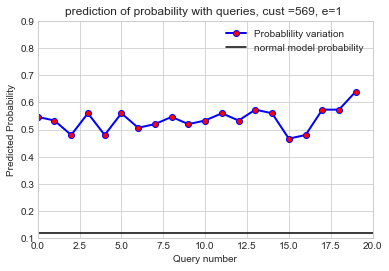

In [79]:
#line graph plotted Dp_proba fluctuatting with different queries for cust =569
import matplotlib.pyplot as plt
x_axis = range(0,20)
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.axhline(y =realpred_p, color = 'black', label ='normal model probability')
plt.ylim(0.1,0.9)
plt.xlim(0,20)
plt.xlabel('Query number')
plt.ylabel('Predicted Probability')
plt.title('prediction of probability with queries, cust =569, e=1 ')
plt.legend()
plt.show()

In [44]:
#cust is customer index
cust =1372
pred =[]
pred_p=[]

from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from diffprivlib.models import RandomForestClassifier

for i in range(0,20):
    model=RandomForestClassifier(n_estimators=75,random_state=30,  epsilon=1, cat_feature_threshold=10, n_jobs=1, verbose=0, accountant=None,max_depth=15, feature_domains=None)
    model.fit(X_train,y_train)
    pred.append(model.predict((np.array(X_test.iloc[cust,:])).reshape(1,-1)))
    pred_p.append(model.predict_proba((np.array(X_test.iloc[cust,:])).reshape(1,-1))[:,0])

C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `feature_domains` according to the documentation
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\arya.raman\Anaconda3\lib\site-packages\diffprivlib\models\forest.py:189: PrivacyLeakWarning: `feature_domains` parameter hasn't been specified, so falling back to determining domains from the data.
This may result

In [45]:
pred_p

[array([0.84]),
 array([0.90666667]),
 array([0.84]),
 array([0.86666667]),
 array([0.86666667]),
 array([0.85333333]),
 array([0.84]),
 array([0.84]),
 array([0.84]),
 array([0.86666667]),
 array([0.85333333]),
 array([0.86666667]),
 array([0.86666667]),
 array([0.88]),
 array([0.90666667]),
 array([0.85333333]),
 array([0.82666667]),
 array([0.88]),
 array([0.88]),
 array([0.82666667])]

In [53]:
#prediction probability for label 0 for cust =1372 with normal model

realpred_p=1-realpred_proba[1372]
realpred_p

0.8

In [36]:
#actual label of cust 1372
y_test[1372]

0

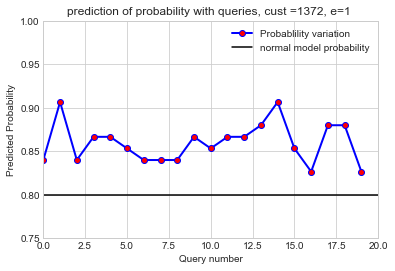

In [55]:
#line graph plotted Dp_proba fluctuatting with different queries for cust =1372
import matplotlib.pyplot as plt
x_axis = range(0,20)
y_axis = pred_p
plt.plot(x_axis, y_axis, color = 'blue', linewidth =2, marker ='o', markerfacecolor ='red', markersize =6, label ='Probablility variation')
plt.style.use('seaborn-whitegrid')
plt.axhline(y =realpred_p, color = 'black', label ='normal model probability')
plt.ylim(0.75,1.0)
plt.xlim(0,20)
plt.xlabel('Query number')
plt.ylabel('Predicted Probability')
plt.title('prediction of probability with queries, cust =1372, e=1 ')
plt.legend()
plt.show()